# MolMap to CYP450 dataset (dual-path approach)

### Load data

In [2]:
import numpy as np
import pandas as pd

# read data CYP
data = pd.read_csv("../../../data/CYP450.csv.gz", compression='gzip')

Set up

In [3]:
# keep desired columns
data = data[['smiles', 'label_2c9']]

# drop molecules with NaN activity
data = data.dropna(subset = ["label_2c9"])

# set smiles
smi = data['smiles']

# set Y
Y = pd.get_dummies(data['label_2c9']).values

# number of active and inactive molecules
print("Inactive (0):", Y[:,1].tolist().count(0))
print("Active (1):", Y[:,1].tolist().count(1))

Inactive (0): 7429
Active (1): 2621


### Do MolMap: from MolDs & FFs to Fmaps

In [4]:
import pickle
from pathlib import Path
from molmap import MolMap
from molmap import feature

X1_file = Path("../../../files/CYP450/molmap/X1.data")
X2_file = Path("../../../files/CYP450/molmap/X2.data")

if X1_file.is_file() and X2_file.is_file():
    'If it exists, we load it.'
    with open(X1_file, "rb") as f:
        X1 = pickle.load(f)
    with open(X2_file, "rb") as f:
        X2 = pickle.load(f)

else: 
    'Otherwise, we compute it and save it to disk.'
    # compute MolDs
    mp1 = MolMap(ftype='descriptor', metric='cosine',)
    mp1.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15,)
    
    # compute FFs
    bitsinfo = feature.fingerprint.Extraction().bitsinfo
    flist = bitsinfo[bitsinfo.Subtypes.isin(['PubChemFP', 'MACCSFP', 'PharmacoErGFP'])].IDs.tolist()
    mp2 = MolMap(ftype = 'fingerprint', fmap_type = 'scatter', flist = flist) 
    mp2.fit(method = 'umap',  min_dist = 0.1, n_neighbors = 15, verbose = 0)

    # get Fmaps
    X1 = mp1.batch_transform(smi)
    X2 = mp2.batch_transform(smi)

    # save in disk
    with open(X1_file, "wb+") as f:
        pickle.dump(X1, f, pickle.HIGHEST_PROTOCOL)
    with open(X2_file, "wb+") as f:
        pickle.dump(X2, f, pickle.HIGHEST_PROTOCOL)

### Split train, validation and test

In [5]:
import sys
sys.path.append("../../../src")
from utils import Rdsplit

train_idx, valid_idx, test_idx = Rdsplit(data, random_state = 888)

8040 1005 1005


In [6]:
trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX = (X1[test_idx], X2[test_idx])

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

### Build MolMapNet model (MultiClassEstimator)

In [7]:
from molmap.model import MultiClassEstimator

clf = MultiClassEstimator(n_outputs=trainY.shape[1], 
                          fmap_shape1 = X1.shape[1:],
                          fmap_shape2 = X2.shape[1:],
                          metric='ROC', 
                          dense_layers = [128, 64], gpuid = 0, epochs = 100) 

MultiClassEstimator(epochs=100, fmap_shape1=(37, 37, 13),
                    fmap_shape2=(72, 72, 3), gpuid='0', n_outputs=2)


### Train model

In [8]:
clf.fit(trainX, trainY, validX, validY)

epoch: 0001, loss: 0.5645 - val_loss: 0.5582; auc: 0.8342 - val_auc: 0.8179                                                                                                    
epoch: 0002, loss: 0.4819 - val_loss: 0.4506; auc: 0.8508 - val_auc: 0.8408                                                                                                    
epoch: 0003, loss: 0.4069 - val_loss: 0.4115; auc: 0.8752 - val_auc: 0.8629                                                                                                    
epoch: 0004, loss: 0.3908 - val_loss: 0.3982; auc: 0.8880 - val_auc: 0.8717                                                                                                    
epoch: 0005, loss: 0.3658 - val_loss: 0.3890; auc: 0.8964 - val_auc: 0.8777                                                                                                    
epoch: 0006, loss: 0.3515 - val_loss: 0.3830; auc: 0.9036 - val_auc: 0.8814                                             

MultiClassEstimator(epochs=100, fmap_shape1=(37, 37, 13),
                    fmap_shape2=(72, 72, 3), gpuid='0', n_outputs=2)

### Plot training history

<AxesSubplot:title={'center':'Performance Learning Curve'}>

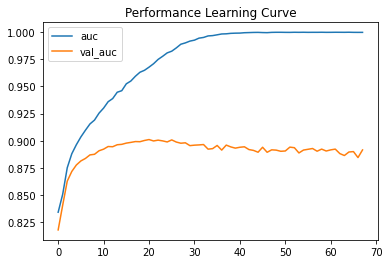

In [9]:
pd.DataFrame(clf.history)[['auc', 'val_auc']].plot(title="Performance Learning Curve")

<AxesSubplot:title={'center':'Optimization Learning Curve'}>

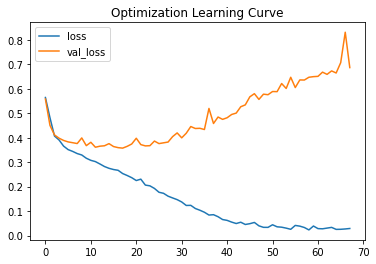

In [10]:
pd.DataFrame(clf.history)[['loss', 'val_loss']].plot(title="Optimization Learning Curve")

In [11]:
print('Best epochs: %.2f, Best loss: %.2f' % (clf._performance.best_epoch, clf._performance.best))

Best epochs: 17.00, Best loss: 0.36


### Calibration curve

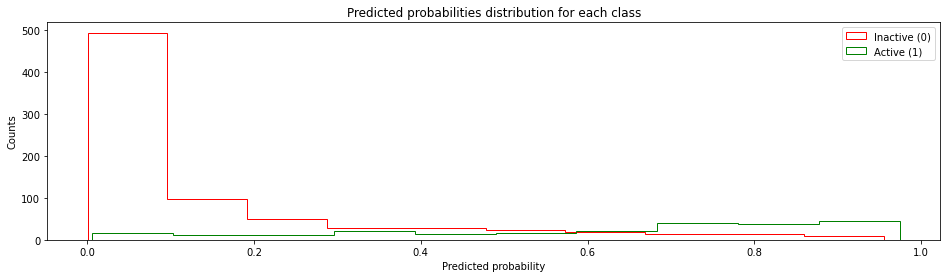

In [12]:
import matplotlib.pyplot as plt

# predict probabilities
df_pred = pd.DataFrame([testY[:, 1], clf.predict_proba(testX)[:,1]]).T
df_pred.columns=['y_true', 'y_pred_prob']

# distributions for each class
dist0 = df_pred[df_pred['y_true'] == 0]['y_pred_prob'].tolist()
dist1 = df_pred[df_pred['y_true'] == 1]['y_pred_prob'].tolist()

# plot
plt.figure(figsize=(16, 4))
plt.title('Predicted probabilities distribution for each class')
plt.hist(dist0,histtype='step', label="Inactive (0)", color='r')  
plt.hist(dist1,histtype='step', label="Active (1)", color='g')
plt.xlabel('Predicted probability')
plt.ylabel('Counts')
plt.legend()
plt.show()

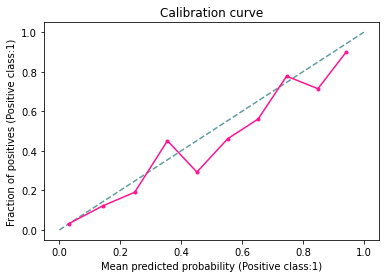

In [13]:
from sklearn.calibration import calibration_curve

# reliability diagram
fop, mpv = calibration_curve(df_pred['y_true'], df_pred['y_pred_prob'], n_bins=10)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', c='cadetblue')

# plot model reliability
plt.title('Calibration curve')
plt.plot(mpv, fop, marker='.', c='deeppink')
plt.xlabel('Mean predicted probability (Positive class:1)')
plt.ylabel('Fraction of positives (Positive class:1)')
plt.show()

### Evaluation on test set: AUC

In [14]:
auc = clf.score(testX, testY) 
print(round(auc,3))

0.9


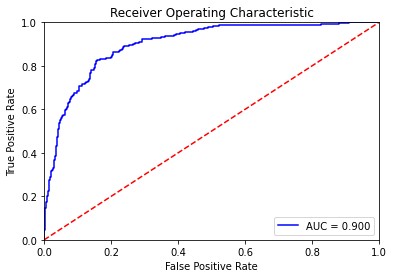

In [15]:
from sklearn import metrics

# ROC curve
fpr, tpr, threshold = metrics.roc_curve(df_pred['y_true'], df_pred['y_pred_prob'])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()